<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-crypto/blob/main/ES_CR_Cap%C3%ADtulo_05_Estrategias_Avanzadas_en_Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>


# Estrategias Avanzadas en Crypto

### Resumen
* Manejar los Datos
* Selección de Características
* Dividir los Datos
* Estandardización
* Análisis de Componentes Principales
* Modelos de Machine Learning
* Cálculo de los Beneficios
* Automatización

<br>


💰 Únete a la comunidad de [Discord](https://discord.gg/z3dx5XpkX4)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.es/Python-para-finanzas-trading-algor%C3%ADtmico-ebook/dp/B0BT4ZS9Q3/)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español


In [1]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=4726e807a69859f0b64d1cea5c196be289f9262ed585045b46b1bea0719e1b3f
  Stored in directory: /root/.cache/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta


In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Este código te permite intercambiar los gráficos por defecto para mostrarlos en el modo oscuro
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [5]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # Función para darle el formato a la fecha
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df

  def drawdown_function(serie):

    # Calculamos la suma acumulada de los retornos
    cum = serie.dropna().cumsum() + 1

    # Calculamos el máximo de la suma acumulada hasta el momento dado (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # Calculamos el drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Importamos el benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Le cambiamos el nombre
  sp500.name = "SP500"

  try:
    # Concatenamos con los datos de sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Formateamos correctamente las fechas
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concatenamos los retornos con los datos de sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  # Calculamos el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calculamos el drawdown máximo
  max_drawdown = -np.min(drawdown)




  # Elaboramos sub gráficos para cada apartado
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Colocamos un Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Representamos el gráfico
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

# Manejo de los datos

In [6]:
def prepocessing(name):
  # Importar los datos
  df = pd.read_csv(name, delimiter="\t", parse_dates=True, index_col="<DATE>")
  
  # Eliminamos las dos últimas columnas
  df = df.iloc[:,:-2]

  # Renombramos las columnas
  df.columns = ["open", "high", "low", "close", "volume"]
  df.index.name = "date"

  return df
  
df = prepocessing("LTCUSD_D1.csv")
df

,open,high,low,close,volume
date,,,,,
2013-01-12,0.070,0.070,0.070,0.070,356
2013-01-13,0.070,0.070,0.070,0.070,321
2013-01-14,0.060,0.060,0.050,0.060,1148
2013-01-15,0.060,0.060,0.060,0.060,253
2013-01-16,0.060,0.060,0.060,0.060,301
...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540
2022-01-06,136.065,137.965,129.767,136.365,25750
2022-01-07,136.365,136.965,125.937,132.393,29927


# Selección de características

In [7]:
def feature_engineering(df, lag=10):
    """ Crea nuevas variables"""
    
    # Hacemos una copia del dataframe para evitar interferencias en los datos
    df_copy = df.dropna().copy()
    
    # Creamos los retornos
    df_copy["return"] = df_copy["close"].pct_change(1)
    df_copy["return_lag"] = df_copy["close"].pct_change(lag)


    # Creamos las volatilidades
    df_copy["MSD 10"] = df_copy[["return"]].rolling(10).std().shift(lag)
    df_copy["MSD 30"] = df_copy[["return"]].rolling(30).std().shift(lag)

    
    # Creamos el Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy["high"], df_copy["low"])
    df_copy["ichimoku_a"] = IC.ichimoku_a().shift(lag)
    df_copy["ichimoku_b"] = IC.ichimoku_b().shift(lag)
    df_copy["ichimoku_base"] = IC.ichimoku_base_line().shift(lag)
    df_copy["ichimoku_conversion"] = IC.ichimoku_conversion_line().shift(lag)

    
    return df_copy.dropna()

In [8]:
# Import TA library
import ta

# Create the features
dfc = feature_engineering(df, lag=1)

dfc

,open,high,low,close,volume,return,return_lag,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion
date,,,,,,,,,,,,,
2013-02-12,0.080,0.080,0.070,0.070,893,-0.125000,-0.125000,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750
2013-02-13,0.070,0.080,0.070,0.070,604,0.000000,0.000000,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750
2013-02-14,0.070,0.070,0.070,0.070,581,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-15,0.070,0.070,0.070,0.070,986,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-16,0.080,0.080,0.080,0.080,847,0.142857,0.142857,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540,-0.077919,-0.077919,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610
2022-01-06,136.065,137.965,129.767,136.365,25750,0.002205,0.002205,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120
2022-01-07,136.365,136.965,125.937,132.393,29927,-0.029128,-0.029128,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680


In [9]:
dfc.iloc[:,7:]

,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion
date,,,,,,
2013-02-12,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750
2013-02-13,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750
2013-02-14,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-15,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-16,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
...,...,...,...,...,...,...
2022-01-05,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610
2022-01-06,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120
2022-01-07,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680


In [10]:
# Calcular el valor que deja el 66% de los valores ordenados por debajo de él (percentile 67)
np.quantile(dfc["return_lag"].dropna(),0.67)

0.011764705882353121

In [11]:
# Creamos variables dummy:
# 0 --> la variación es inferior al percentil 67
# 1 --> la variación es superior al percentil 67
dfc["dummy"] = 0
percentile = np.quantile(dfc["return_lag"].dropna(),0.67)
dfc.loc[dfc["return_lag"]>percentile, "dummy"] = 1

In [12]:
dfc

,open,high,low,close,volume,return,return_lag,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,dummy
date,,,,,,,,,,,,,,
2013-02-12,0.080,0.080,0.070,0.070,893,-0.125000,-0.125000,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750,0
2013-02-13,0.070,0.080,0.070,0.070,604,0.000000,0.000000,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750,0
2013-02-14,0.070,0.070,0.070,0.070,581,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,0
2013-02-15,0.070,0.070,0.070,0.070,986,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,0
2013-02-16,0.080,0.080,0.080,0.080,847,0.142857,0.142857,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540,-0.077919,-0.077919,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610,0
2022-01-06,136.065,137.965,129.767,136.365,25750,0.002205,0.002205,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120,0
2022-01-07,136.365,136.965,125.937,132.393,29927,-0.029128,-0.029128,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680,0


# Dividimos los datos

In [13]:
# Porcentaje del conjunto de entrenamiento
split = int(0.90 * len(dfc))

# Creamos el conjunto de entrenamiento
X_train = dfc.iloc[:split, 7:-1]
y_train = dfc[["dummy"]].iloc[:split]


# Creamos el conjunto de test
X_test = dfc.iloc[split:, 7:-1]
y_test = dfc[["dummy"]].iloc[split:]

# Estandarización

In [14]:
# Estandarización
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

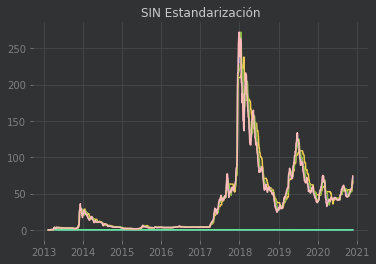

In [15]:
plt.plot(X_train)
plt.title("SIN Estandarización")
plt.show()

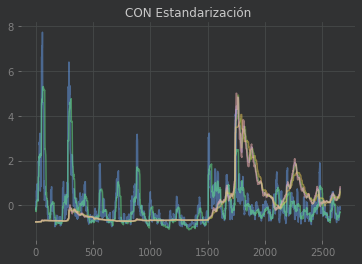

In [16]:
plt.plot(X_train_sc, alpha=0.5)
plt.title("CON Estandarización")
plt.show()

# Análisis de Componentes Principales

In [17]:
# Reducción de la Dimensión
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

# Modelo de Machine Learning

In [18]:
# Importar la clase
from sklearn.ensemble import RandomForestClassifier

# Inicializar la clase
cla = RandomForestClassifier(max_depth=3, n_estimators=100)

# Ajustar el modelo
np.random.seed(56)
cla.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=3)

# Predicción

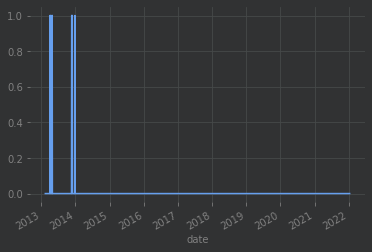

In [19]:
# Crear predicciones de todo el conjunto de datos
X = np.concatenate((X_train_pca, X_test_pca), axis=0)

dfc["prediction"] = cla.predict(X)

# Verificamos que el algoritmo no predice solamente en un sentido (positivo o negativo)
dfc["prediction"].plot()

# Calculamos los beneficios

[*********************100%***********************]  1 of 1 completed


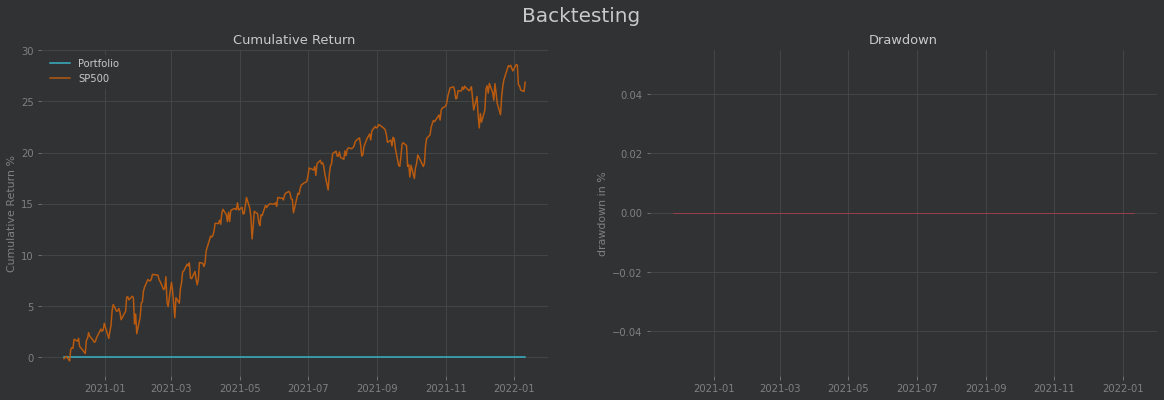

Sortino: nan
Beta: 0.0
Alpha: 0.0 %
MaxDrawdown: -0.0 %


In [ ]:
import yfinance as yf
# Calculamos la posición
dfc["position"] = dfc["prediction"]

lag = 1

# Calculamos el retorno
dfc["strategy"] = np.array([dfc["return"].shift(i) for i in range(lag)]).sum(axis=0) * (dfc["position"].shift(lag))
#dfc["strategy"] = dfc["return"] * dfc["position"].shift(1)

dfc["return"] = dfc["strategy"]
BackTest(dfc["return"].iloc[split:])

# Automatización

In [20]:
def RandomForest(name,lag=10):

  def feature_engineering(df, lag=10):
    """ Creamos las nuevas variables """
    lag = 10
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["returns_lag"] = df_copy["close"].pct_change(lag)
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(lag)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(lag)
    
    # Create the Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy["high"], df_copy["low"])
    df_copy["ichimoku_a"] = IC.ichimoku_a().shift(lag)
    df_copy["ichimoku_b"] = IC.ichimoku_b().shift(lag)
    df_copy["ichimoku_base"] = IC.ichimoku_base_line().shift(lag)
    df_copy["ichimoku_conversion"] = IC.ichimoku_conversion_line().shift(lag)
    
    return df_copy.dropna()

  def prepocessing(name):
    df = pd.read_csv(name, delimiter="\t", parse_dates=True, index_col="<DATE>")
    df = df.iloc[:,:-2]
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "date"

    return df
  
  df = prepocessing(name)
  import ta
  dfc = feature_engineering(df, lag)
  

  dfc["dummy"] = 0
  dfc.loc[dfc["returns_lag"]>np.quantile(dfc["returns_lag"],0.67),"dummy"]=1

  # Percentage train set
  split = int(0.90*len(dfc))

  # Train set creation
  X_train = dfc.iloc[:split,7:-1]
  y_train = dfc[["dummy"]].iloc[:split]


  # Test set creation
  X_test = dfc.iloc[split:,7:-1]
  y_test = dfc[["dummy"]].iloc[split:]

  # STANDARDISATION
  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)

  # DIMENSION REDUCTION
  from sklearn.decomposition import PCA
  pca = PCA(n_components=5)

  X_train_pca = pca.fit_transform(X_train_sc)
  X_test_pca = pca.transform(X_test_sc)

  # Import the class
  from sklearn.ensemble import RandomForestClassifier

  # Initialize the class
  reg = RandomForestClassifier(max_depth=3, n_estimators=100)

  # Fit the model
  np.random.seed(56)
  reg.fit(X_train_pca, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train_pca, X_test_pca), axis=0)

  #dfc["proba"] = reg.predict_proba(X)[:,0:1].reshape(-1,1)
  dfc["prediction"] = reg.predict(X)

  import yfinance as yf
  # Compute the position
  dfc["position"] = dfc["prediction"]

  # Compute the returns
  dfc["strategy"] = np.array([dfc["returns"].shift(i) for i in range(lag)]).sum(axis=0) * (dfc["position"].shift(lag))
  #dfc["strategy"] = dfc["returns"] * dfc["position"].shift(lag)

  dfc["return"] = dfc["strategy"].dropna()
  return dfc["return"].iloc[split:]/lag

[*********************100%***********************]  1 of 1 completed


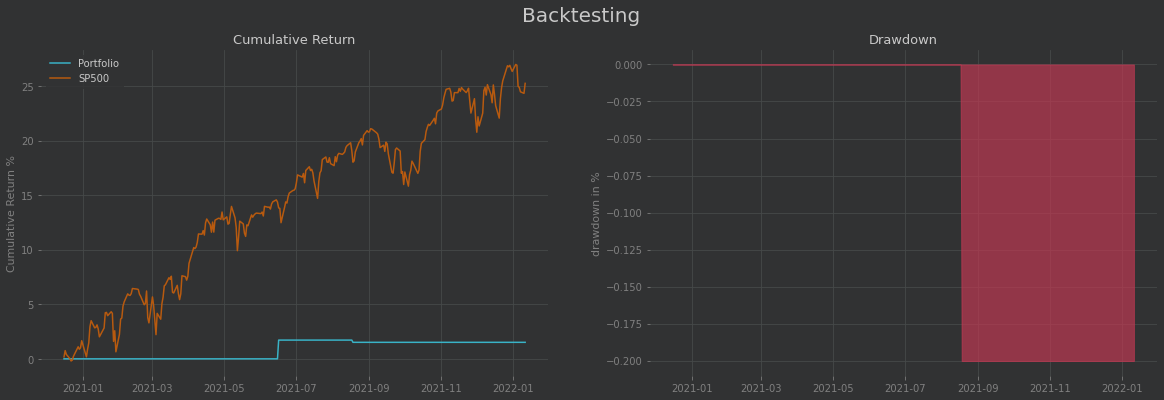

Sortino: nan
Beta: -0.005
Alpha: 0.282 %
MaxDrawdown: 0.2 %
[*********************100%***********************]  1 of 1 completed


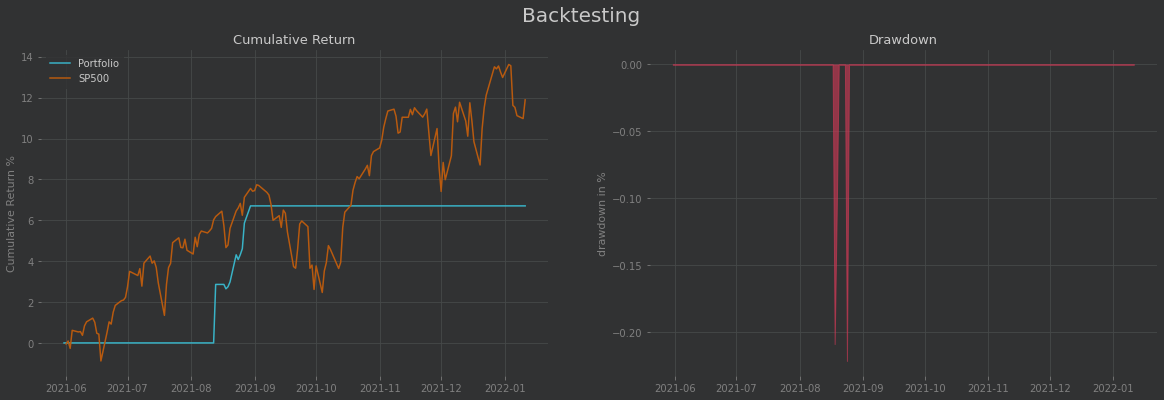

Sortino: 26.066
Beta: 0.031
Alpha: 2.085 %
MaxDrawdown: 0.222 %
[*********************100%***********************]  1 of 1 completed


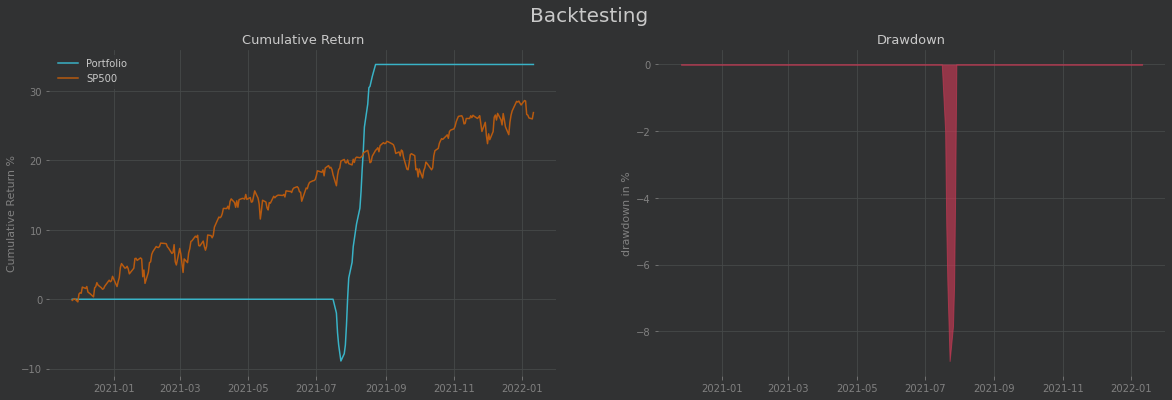

Sortino: 1.188
Beta: -0.014
Alpha: 6.047 %
MaxDrawdown: 8.892 %
[*********************100%***********************]  1 of 1 completed


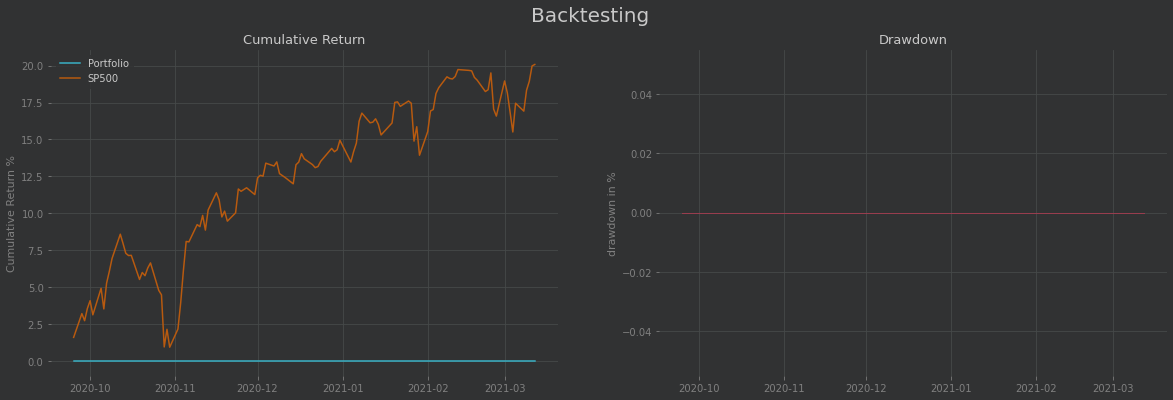

Sortino: nan
Beta: 0.0
Alpha: 0.0 %
MaxDrawdown: -0.0 %
[*********************100%***********************]  1 of 1 completed


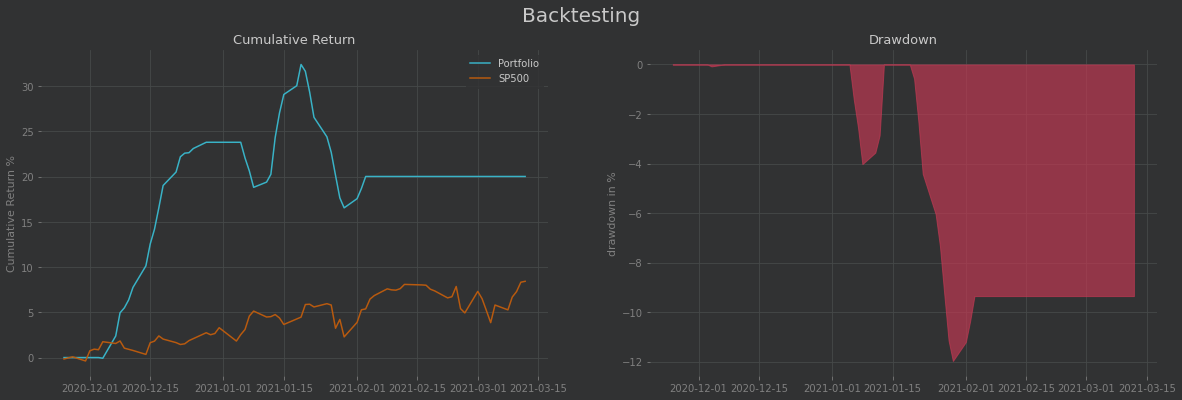

Sortino: 2.345
Beta: 0.077
Alpha: 12.475 %
MaxDrawdown: 11.973 %


In [21]:
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]
returns = pd.DataFrame()
for name in namelist:
  ret = RandomForest(f"{name}USD_D1.csv", lag=7)
  returns = pd.concat((returns,ret),axis=1)
  BackTest(ret, 52)